# HSE 2025: Mathematical Methods for Data Analysis

## Seminar 6: Introduction to Natural Language Processing

**Author**: Maria Tikhonova, Eugeny Sokolov


## What is Natural Language processing?

Computers are great at working with structured data like spreadsheets and database tables. But us humans usually communicate in words, not in tables. That’s unfortunate for computers.

A lot of information in the world is unstructured — raw text in English or another human language. How can we get a computer to understand unstructured text and extract data from it?


**Natural Language Processing, or NLP,** is the sub-field of AI that is focused on enabling computers to understand and process human languages.

Great [article](https://medium.com/@ageitgey/natural-language-processing-is-fun-9a0bff37854e) on Medium about NLP! **MUST READ!**

Good [post](https://habr.com/ru/company/Voximplant/blog/446738/) on HABR about basics of NLP.

[Introductory overview of NLP](https://tfduque.medium.com/dissecting-natural-language-processing-layer-by-layer-an-introductory-overview-d11cfff4f329)

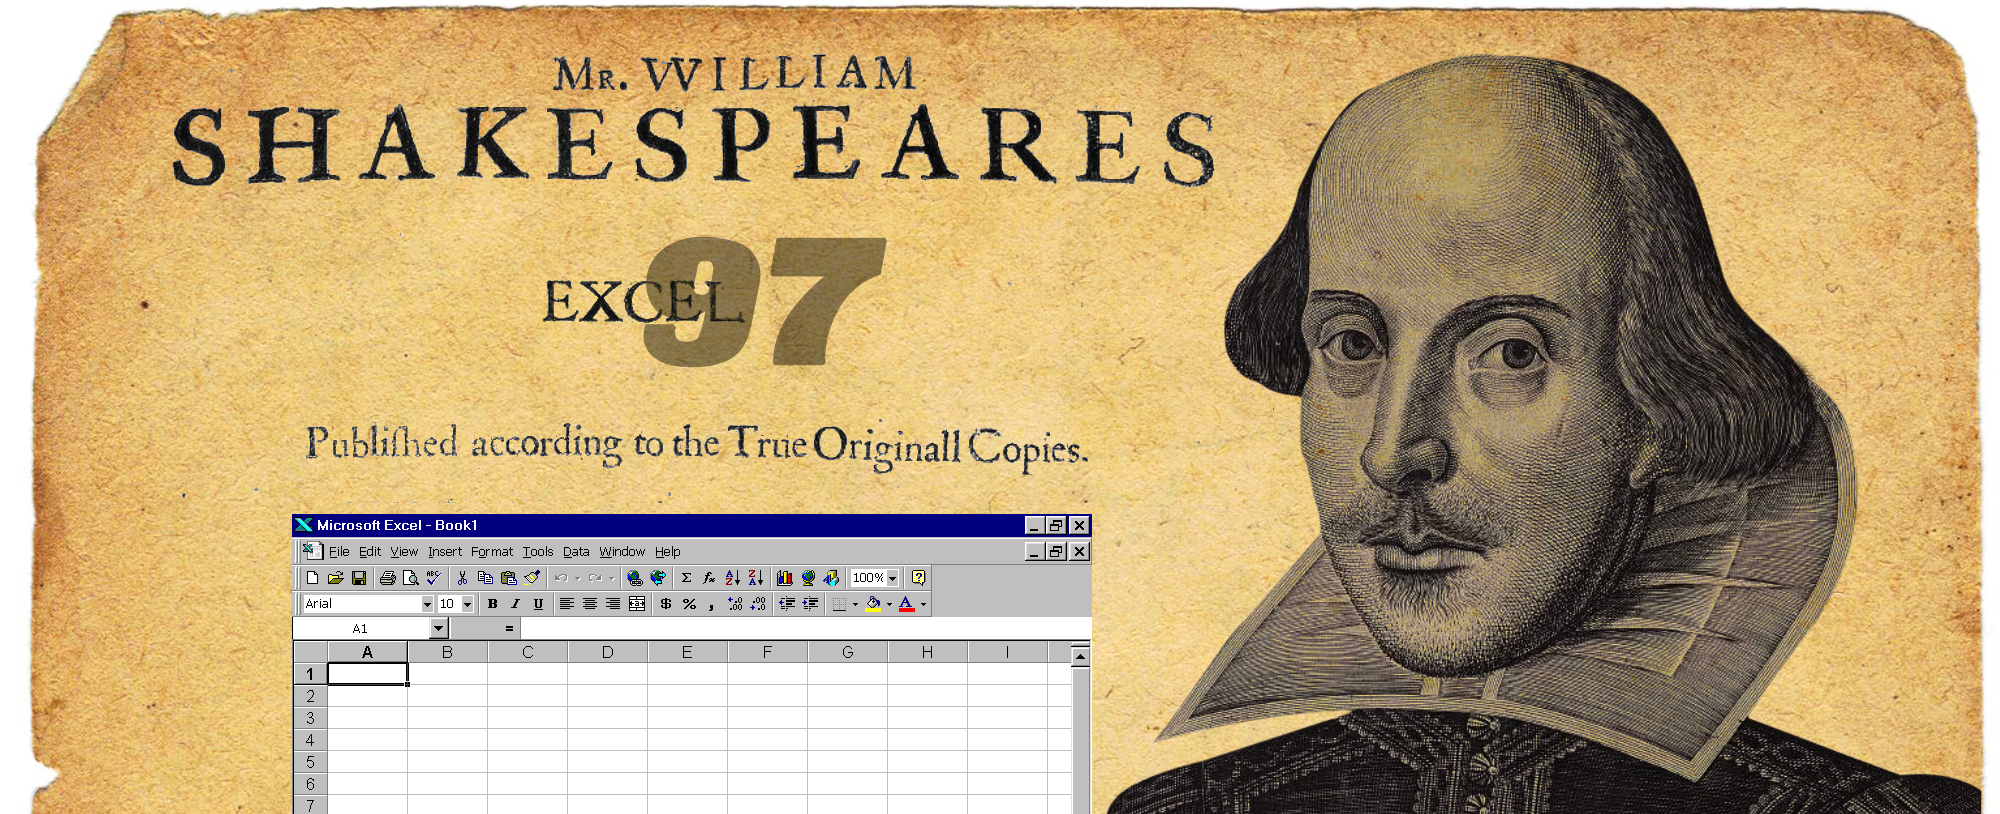

Picture is taken from [this site](https://medium.com/@ageitgey/natural-language-processing-is-fun-9a0bff37854e).

In [ ]:
%matplotlib inline
! pip install pymorphy3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import seaborn as sns


from tqdm import tqdm_notebook
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 25.3 MB/s eta 0:00:00


# Sentiment Analysis

Today we are going to study basics of NLP on the example of Sentiment Analysis task from [Kaggle Competition](https://www.kaggle.com/c/sentiment-analysis-in-russian/data) .

The goal is to estimate news sentiment in Russian.

## Load data

In [ ]:
! wget https://raw.githubusercontent.com/hushchyn-mikhail/hse_se_ml/s08/2020/s08-nlp/Data/train.json

--2024-10-19 14:19:02--  https://raw.githubusercontent.com/hushchyn-mikhail/hse_se_ml/s08/2020/s08-nlp/Data/train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59298269 (57M) [text/plain]
Saving to: ‘train.json’

train.json          100%[===================>]  56.55M   104MB/s    in 0.5s    

2024-10-19 14:19:04 (104 MB/s) - ‘train.json’ saved [59298269/59298269]



In [ ]:
# Load data

with open('train.json', encoding = 'utf-8') as json_file:
    data = json.load(json_file)

The task is a 3-class classification problem.

In [ ]:
print(set([x["sentiment"] for x in data]))

{'neutral', 'positive', 'negative'}


Each sample contains a piece of text and a sentiment label (`'positive', 'negative', 'neutral'`). The goal is to predict the label.

In [ ]:
# Show example
num = 1 # 100 - pos

print("ID: ",          data[num]["id"], "\n")
print("Text: \n",      data[num]["text"])
print("Sentiment: ",   data[num]["sentiment"], "\n")

ID:  1957 

Text: 
 Медики рассказали о состоянии пострадавшего мужчины, на которого было совершено нападение возле отделения банка по Тимирязева. Как прокомментировали Tengrinews.kz в пресс-службе Управления здравоохранения Алматы, с места происшествия в службу скорой помощи обратились двое человек. 

«Одному из них на месте была оказана медицинская помощь. От госпитализации он отказался. Второй пациент был доставлен в больницу скорой неотложной помощи (БСНП) с сотрясением головного мозга, ушибленной раной головы. Состояние на данный момент оценивается ближе к удовлетворительному. Пока он проходит обследование в больнице», — сообщили в Управлении здравоохранения Алматы.  

Напомним, в Алматы на пересечении улиц Тимирязева и Маркова возле БЦ «Алатау Гранд» произошла стрельба, ориентировочно в обеденное время. В здании расположены отделения банков «ВТБ» и «Сбербанк». 

В настоящее время полицейские разыскивают подозреваемых в стрельбе. По факту нападения в местном управлении внутренних 

# Preprocessing Pipeline
Before applying any ML algorithm, the text should be preprocessed.

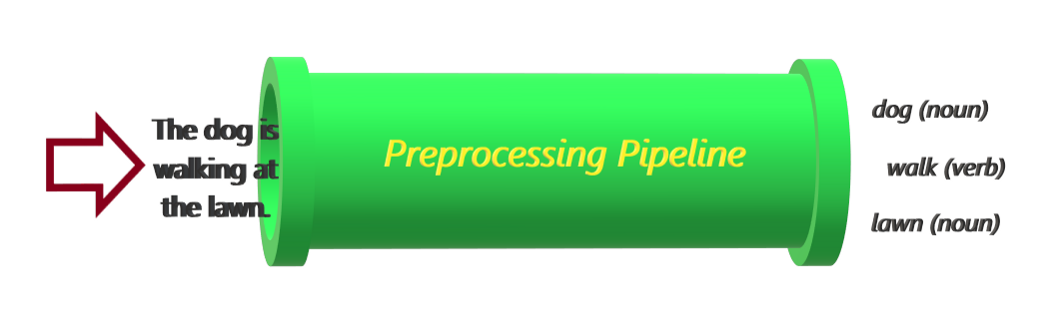

Picture is from [here.](https://medium.com/analytics-vidhya/nlp-preprocessing-pipeline-what-when-why-2fc808899d1f)

##1 step. Tokenization and data cleaning

The first step is to split the text into units we are going to work with. This units are called **tokens**, and the process itself is called **tokenization.** In most cases we take words as such tokens, but sometimes we want to work with n-gramms or letters.


On this seminar we will work on word-level. Most easy way to split the text into words (or tokens) is to split it by spaces (correctly handling punctuation).

##2 step. Removing stop words

In every language there are a lot of filler words that appear very frequently like “and”, “the”, and “a” in English. When doing statistics on text, these words introduce a lot of noise since they appear way more frequently than other words. Such words are called **stop words** and are commonly ignored in most NLP-algorithm. Thus, on the 2nd step we remove stop-words from the text.





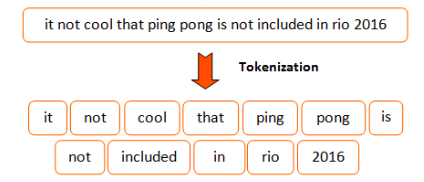

In [ ]:
import string # for work with strings
import nltk   # Natural Language Toolkit

In [ ]:
# get russian stop words
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

# example of stop words
stop_words[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [ ]:
# punctuation characters
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# define word tokenizer
word_tokenizer = nltk.WordPunctTokenizer()
word_tokenizer.tokenize('Доброе утро! Как у вас дела?...')

['Доброе', 'утро', '!', 'Как', 'у', 'вас', 'дела', '?...']

In [ ]:
dates = [str(x) for x in np.arange(1900, 2022)]
def process_data(data):
    texts = []
    targets = []

    for item in data:

        # collect nlabels of news


        text_lower = item['text'].lower() # convert words in a text to lower case
        tokens     = word_tokenizer.tokenize(text_lower) # splits the text into tokens (words)

        # remove punct and stop words from tokens
        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and word not in dates)]

        texts.append(tokens) # collect the text tokens

    return texts

In [ ]:
# run tokenization and data cleaning
y = [item['sentiment'] for item in data]
texts = process_data(data)

In [ ]:
# example
i = 1
print("Label: ", y[i])
print("Tokens: ", texts[i][:5])

Label:  negative
Tokens:  ['медики', 'рассказали', 'состоянии', 'пострадавшего', 'мужчины']


## 3 step. Words normalization

There exist 2 most common ways of words normalizing: **stemming** and **lemmatization**. They are slightly different and in different languages the one or the other is prefferes.

**1) Stemming**
A Stem is the “core structure” of a plant. All leaves are connected to distinct parts of the Stem. A similar concept can be applied to words. Words are leaves, their “core” are stems (think of a trie data structure if you know what I mean). Stemming is the process of reducing each word (encompassed by a token) to its core elements, reducing temporal, gender (if that’s the language case) and grade variety (considering that this information is appended to the last part of the word).

**2) Lemmatization** converts a word to its normal form.

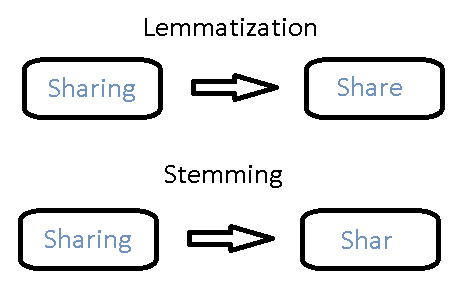

In [ ]:
from nltk.stem.snowball import SnowballStemmer

# define stemmer
stemmer = SnowballStemmer("russian")

In [ ]:
# example of its work
i = 1
for aword in texts[i][:10]:
    aword_stem = stemmer.stem(aword)
    print("Before: %s, After: %s" % (aword, aword_stem))

Before: медики, After: медик
Before: рассказали, After: рассказа
Before: состоянии, After: состоян
Before: пострадавшего, After: пострада
Before: мужчины, After: мужчин
Before: которого, After: котор
Before: совершено, After: соверш
Before: нападение, After: нападен
Before: возле, After: возл
Before: отделения, After: отделен


In [ ]:
text = 'машинное обучение для анализа данных в высшей школе экономики'
stemmed_text = ' '.join([stemmer.stem(x) for x in text.split(' ')])
print('Original text:\t',text)
print('Stemmed text:\t',stemmed_text)

Original text:	 машинное обучение для анализа данных в высшей школе экономики
Stemmed text:	 машин обучен для анализ дан в высш школ экономик


It could be seen that for the Russian language the result is not that good. The meaning of the sentence becomes umbiguous.

In [ ]:
import pymorphy3 # Морфологический анализатор

# define lemmatizer :)
morph = pymorphy3.MorphAnalyzer()

In [ ]:
# example of its work
i = 1
for aword in texts[i][:10]:
   aword_norm = morph.parse(aword)[0].normal_form
   print("Before: %s, After: %s" % (aword, aword_norm))

Before: медики, After: медик
Before: рассказали, After: рассказать
Before: состоянии, After: состояние
Before: пострадавшего, After: пострадать
Before: мужчины, After: мужчина
Before: которого, After: который
Before: совершено, After: совершить
Before: нападение, After: нападение
Before: возле, After: возле
Before: отделения, After: отделение


In [ ]:
text = 'машинное обучение для анализа данных в высшей школе экономики'
stemmed_text = ' '.join([morph.parse(x)[0].normal_form for x in text.split(' ')])
print('Original text:\t',text)
print('Lemmatized text:\t',stemmed_text)

Original text:	 машинное обучение для анализа данных в высшей школе экономики
Lemmatized text:	 машинный обучение для анализ данные в высокий школа экономика


Much better! The text looks little bit strange but understadable.

**Hint** For complex languages with many word forms, like Russian, it is better to use lemmatization.

## Be careful!
**Pymorphy can be slow. If you do not want to wait, skip the next cell and load already preprocessed texts.**

In [ ]:
# apply stemming to all texts
for i in tqdm_notebook(range(len(texts))):           # tqdm_notebook creates the process bar below :)
    text_lemmatized = [morph.parse(x)[0].normal_form for x in texts[i]] # apply lemmatization to each word in a text
    texts[i] = ' '.join(text_lemmatized)                # unite all stemmed words into a new text

  0%|          | 0/8263 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
!wget -O text_lemmatized.zip 'https://drive.usercontent.google.com/download?id=1oXJlW42X1Z7rCMDHKGJH1DnOHklF30gs&export=download&authuser=0&confirm=t&uuid=d66f3b5d-0c3a-40a9-81df-b6a2d7bd7183&at=AN_67v2Dk8uJ2EukeqLui8PGEUAB:1729347737921'
!unzip text_lemmatized.zip

--2025-10-20 11:01:02--  https://drive.usercontent.google.com/download?id=1oXJlW42X1Z7rCMDHKGJH1DnOHklF30gs&export=download&authuser=0&confirm=t&uuid=d66f3b5d-0c3a-40a9-81df-b6a2d7bd7183&at=AN_67v2Dk8uJ2EukeqLui8PGEUAB:1729347737921
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 192.178.210.132, 2607:f8b0:4001:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|192.178.210.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10717325 (10M) [application/octet-stream]
Saving to: ‘text_lemmatized.zip’

text_lemmatized.zip 100%[===================>]  10.22M  57.8MB/s    in 0.2s    

2025-10-20 11:01:06 (57.8 MB/s) - ‘text_lemmatized.zip’ saved [10717325/10717325]

Archive:  text_lemmatized.zip
  inflating: text_lemmatized.txt     


In [ ]:
#with open('text_lemmatized.txt', 'w', encoding = 'utf-8') as f:
#  for text in texts:
#    f.write(text+'\n')
texts = open('text_lemmatized.txt', encoding = 'utf-8').readlines()

In [ ]:
# example
i = 1
print("Label: ",   y[i])
print("Text: \n",  texts[i])

Label:  negative
Text: 
 медик рассказать состояние пострадать мужчина который совершить нападение возле отделение банк тимирязев прокомментировать tengrinews kz пресс служба управление здравоохранение алматы место происшествие служба скорый помощь обратиться двое человек « один место оказать медицинский помощь госпитализация отказаться второй пациент доставить больница скорый неотложный помощь бснп сотрясение головной мозг ушибить рана голова состояние данный момент оцениваться близкий удовлетворительный пока проходить обследование больница », — сообщить управление здравоохранение алматы напомнить алматы пересечение улица тимирязев марков возле бц « алатау гранд » произойти стрельба ориентировочно обеденный время здание расположить отделение банк « втб » « сбербанк ». настоящий время полицейский разыскивать подозревать стрельба факт нападение местный управление внутренний дело начать досудебный расследование статья 192 ук рк « разбой ». создать специальный следственно оперативный груп

# Modeling & Embeddings

## Split into train and test

We have 3-class classification problem.

First, let us reduce it to binary classification to illustrate embedding methods and then we will see how to solve original 3-class problem.

In [ ]:
from collections import Counter
print(Counter(y))

Counter({'neutral': 4034, 'positive': 2795, 'negative': 1434})


In [ ]:
#train test_split
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_y, test_y = train_test_split(texts, [1 if x == 'positive'  else 0 for x in y ], test_size=0.33, random_state=42, stratify = y)

# Bag of Words model

The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.

The bag-of-words model is commonly used in methods of document classification where the (frequency of) occurrence of each word is used as a feature for training a classifier.

## Example

The following models a text document using bag-of-words. Here are two simple text documents:

```
(1) John likes to watch movies. Mary likes movies too.
(2) Mary also likes to watch football games.
```
Based on these two text documents, a list is constructed as follows for each document:

```
"John","likes","to","watch","movies","Mary","likes","movies","too"
"Mary","also","likes","to","watch","football","games"
```
In the form of the dict it will look like:

```
BoW1 = {"John":1,"likes":2,"to":1,"watch":1,"movies":2,"Mary":1,"too":1};
BoW2 = {"Mary":1,"also":1,"likes":1,"to":1,"watch":1,"football":1,"games":1};
```
If we fix word order, we will obtain word-matrix where each row represents a document and each column corresponds to the word in the vocabulary:
```
BoW = [[1,2,1,1,2,1,1,0,0,0]
      [0,1,1,1,0,1,0,1,1,1]]
```
.

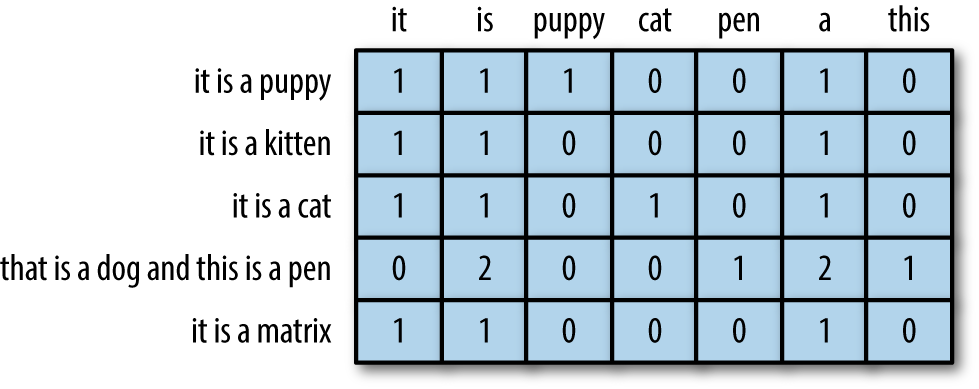

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 50)
vectorizer.fit(train_texts)

# The top 10 words
vectorizer.get_feature_names_out()[:10]

array(['10', 'алматы', 'ао', 'астана', 'банк', 'быть', 'вопрос', 'время',
       'год', 'город'], dtype=object)

In [ ]:
# Apply Bag-Of-Words to train and test texts
train_X = vectorizer.transform(train_texts)
test_X  = vectorizer.transform(test_texts)

In [ ]:
train_X.todense()[:2]

matrix([[ 1,  0,  0,  1,  0,  2,  2,  0,  1,  0,  1,  0,  0,  2,  5,  0,
          0,  3,  2,  0,  4,  0,  2,  0,  0,  2,  1,  0,  0,  0,  1,  0,
          1,  1,  5,  2,  1,  0,  0,  1,  0,  2,  0,  0,  0,  0,  0,  0,
          0,  1],
        [ 1,  0,  3,  2, 11,  5,  6,  4,  5,  0,  2,  1,  6,  2, 14,  3,
          6,  5,  0,  0,  2,  4,  7,  1,  3,  2,  3,  1,  1,  1,  1,  0,
          0,  2,  1,  2,  6,  1,  0,  1,  0,  1,  2,  0,  2,  0,  0,  1,
         15,  1]])

Now every sentence is represented as a vector whish contains word counts of most frequent words. Thus, it is possible to apply standard classification algorithms to it.

## Logistic Regression
## Theory Recap
Logistic Regression is a **classification** model. It's very closely related to linear regression. For some class labels $y \in \{0, 1\}$ and some features $X$  logistic regression models the probability $Pr(y=1 | X)$


The model itself:

$$p(x) = \frac{e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots }}{1 + e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots }} = sigmoid(\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots)$$

In short, the model is simply [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) applied to the output of a linear model.

The output of the linear model is called [*log-odds*](https://en.wikipedia.org/wiki/Logit) (also *logits*) $$\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots = log(\frac{p(x)}{1-p(x)})$$

The sigmoid function turns the log-odds (output from the linear model) into probabilities, so the output of the model is always on the range of $[0, 1]$.

Logistic Regression is not fit using OLS, but via maximum likelihood estimation by optimizing [negative loglikelihood ](https://towardsdatascience.com/log-loss-function-math-explained-5b83cd8d9c83). Usually the optimization is done with gradient descent.

In [ ]:
def show_results(test_y, pred, proba):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:,1]),))
    print('\n')
    labels = ['negative','positive']

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix ")
    plt.show()

Precision:   0.67
Recall:   0.57
F1-measure:   0.55
Accuracy:   0.69
ROC-AUC  =    0.72




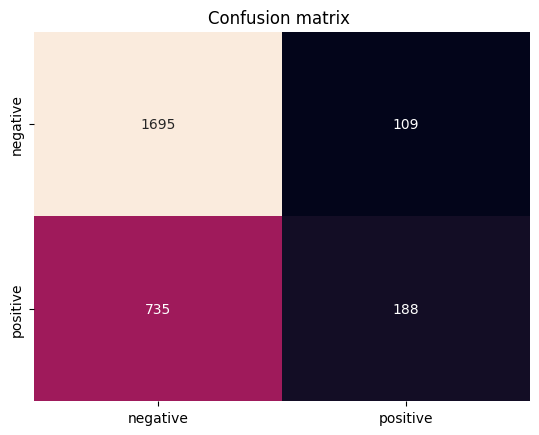

In [ ]:
clf = LogisticRegression(verbose = False)
clf.fit(train_X, train_y)
pred = clf.predict(test_X)
proba  = clf.predict_proba(test_X)
show_results(test_y, pred, proba)

Not bad, but could be improved. Let us try to find best parameters for LogReg via GridSearch.

Best parameters:  {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2'}
Precision:   0.65
Recall:   0.67
F1-measure:   0.65
Accuracy:   0.66
ROC-AUC  =    0.72




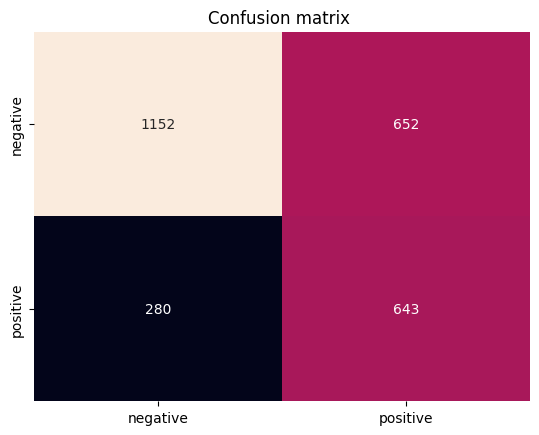

In [ ]:
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight' : ['balanced',None],\
              'penalty':['l1', 'l2', 'elasticnet']}

svr = LogisticRegression(verbose = False)
clf = GridSearchCV(svr, parameters, scoring = 'f1')
clf.fit(train_X, train_y)
pred = clf.predict(test_X)
proba  = clf.predict_proba(test_X)
print('Best parameters: ', clf.best_params_)
show_results(test_y, pred, proba)


F1-score has improved and the confusion matrix looks better.

Let us also study the influence of the embedding size on the result.

Number of features:  100
Precision:   0.67
Recall:   0.69
F1-measure:   0.66
Accuracy:   0.67
ROC-AUC  =    0.74




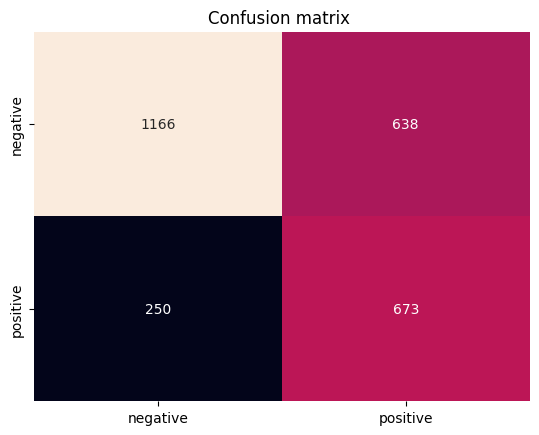





Number of features:  1000
Precision:   0.74
Recall:   0.76
F1-measure:   0.74
Accuracy:   0.75
ROC-AUC  =    0.82




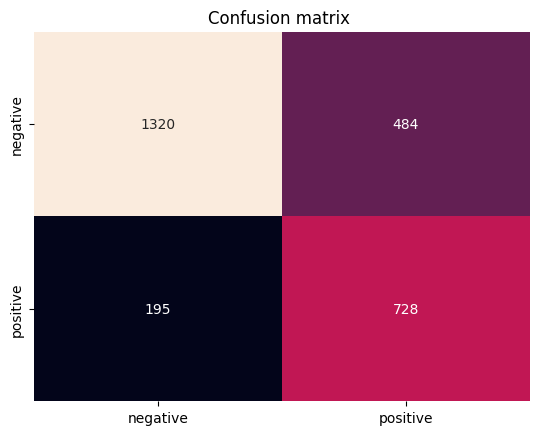





Number of features:  10000
Precision:   0.76
Recall:   0.78
F1-measure:   0.76
Accuracy:   0.78
ROC-AUC  =    0.83




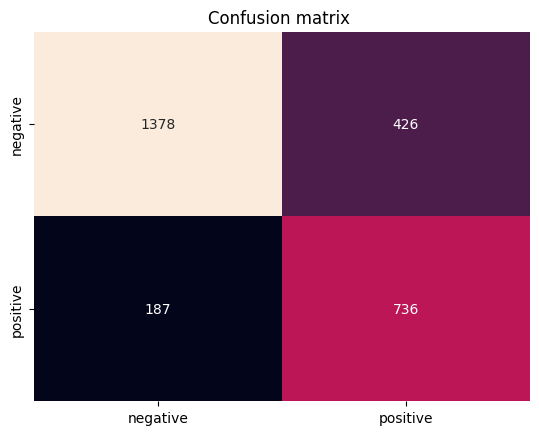





Number of features:  30000
Precision:   0.76
Recall:   0.78
F1-measure:   0.76
Accuracy:   0.77
ROC-AUC  =    0.84




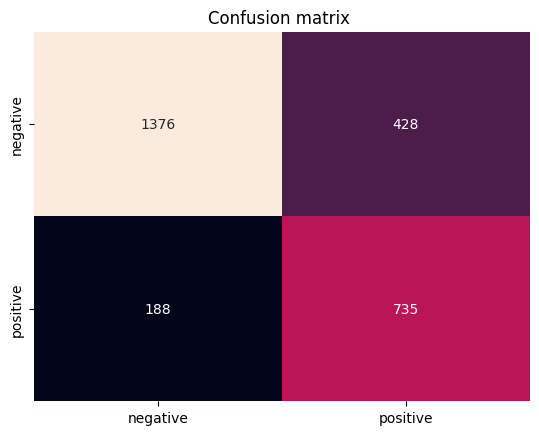





Number of features:  60000
Precision:   0.76
Recall:   0.78
F1-measure:   0.76
Accuracy:   0.77
ROC-AUC  =    0.84




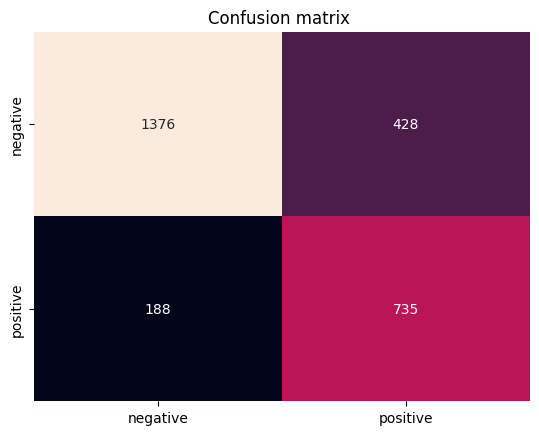





Number of features:  100000
Precision:   0.76
Recall:   0.78
F1-measure:   0.76
Accuracy:   0.77
ROC-AUC  =    0.84




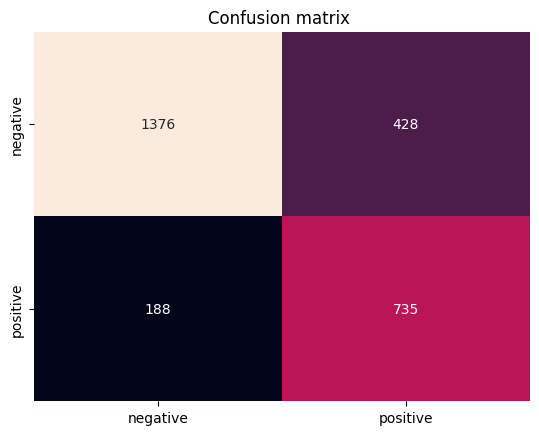

In [ ]:
best_params = {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2'}
f1s = []
word_grid = [100, 1000, 10000, 30000, 60000, 100000]
for max_features in word_grid:
    vectorizer = CountVectorizer(max_features = max_features)
    vectorizer.fit(train_texts)
    train_X = vectorizer.transform(train_texts)
    test_X  = vectorizer.transform(test_texts)
    clf = LogisticRegression(**best_params)
    clf.fit(train_X, train_y)
    pred = clf.predict(test_X)
    proba  = clf.predict_proba(test_X)
    print('Number of features: ', max_features)
    show_results(test_y, pred, proba)
    print('\n\n\n')
    f1s.append(f1_score(test_y, pred))

Text(0.5, 1.0, 'F1 result')

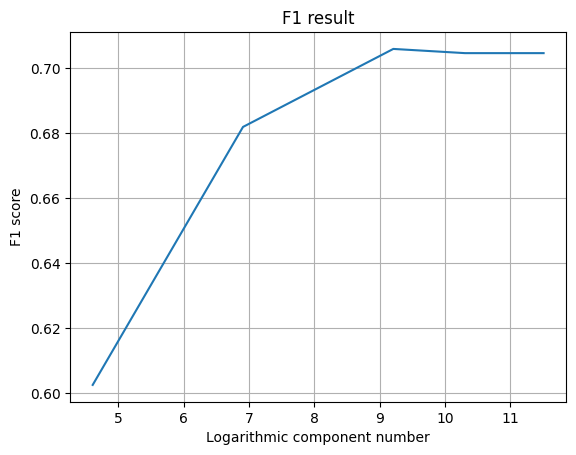

In [ ]:
plt.plot([np.log(x) for x in word_grid], f1s)
plt.grid()
plt.xlabel('Logarithmic component number')
#plt.xlabels([str(x) for x in word_grid])
plt.ylabel('F1 score')

plt.title('F1 result')

Best score is for ~10000 components. That means that we get best result embedding each text with top-10000 most frequent words.

**Task** Iterate over component number, for each perform GridSearch and find the best configuration.

Number of features:  100
Precision:   0.67
Recall:   0.69
F1-measure:   0.66
Accuracy:   0.67
ROC-AUC  =    0.74




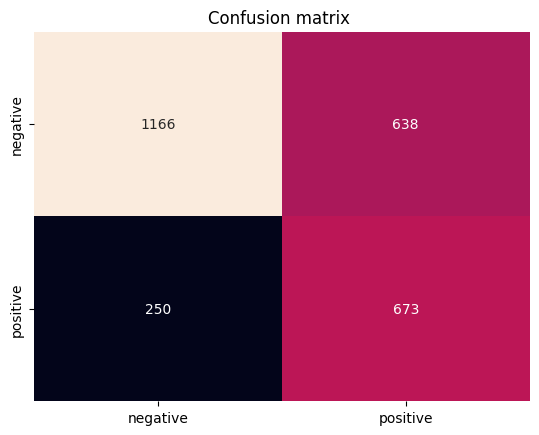





Number of features:  1000
Precision:   0.74
Recall:   0.76
F1-measure:   0.74
Accuracy:   0.75
ROC-AUC  =    0.82




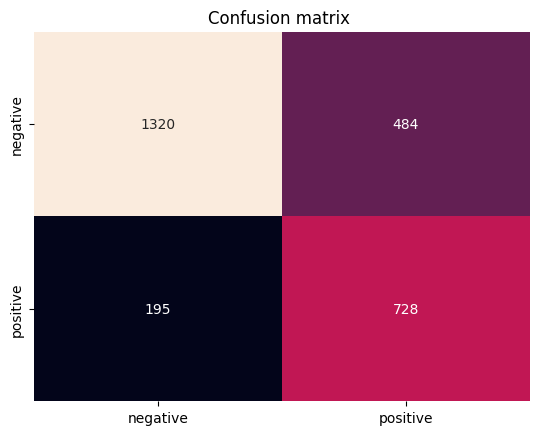





Number of features:  10000
Precision:   0.76
Recall:   0.78
F1-measure:   0.77
Accuracy:   0.79
ROC-AUC  =    0.85




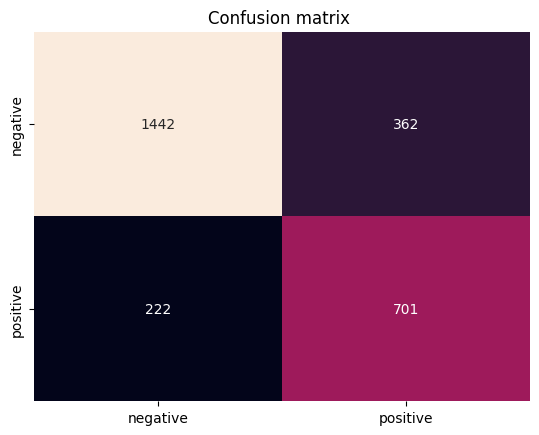





Number of features:  30000
Precision:   0.76
Recall:   0.78
F1-measure:   0.77
Accuracy:   0.79
ROC-AUC  =    0.85




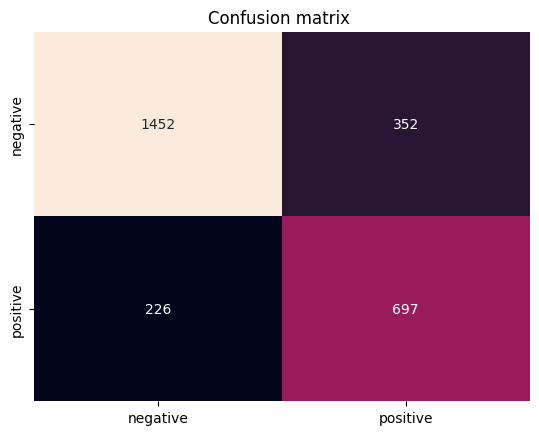

Text(0.5, 1.0, 'F1 result')

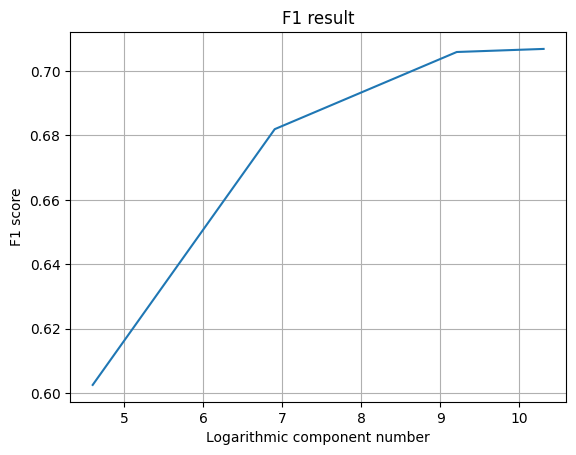

In [ ]:
## YOUR CODE HERE
word_grid = [100, 1000, 10000, 30000]
f1s = []
for max_features in word_grid:
    vectorizer = CountVectorizer(max_features = max_features)
    vectorizer.fit(train_texts)
    train_X = vectorizer.transform(train_texts)
    test_X  = vectorizer.transform(test_texts)
    parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'class_weight' : ['balanced',None],\
              'penalty':['l1', 'l2', 'elasticnet']}

    svr = LogisticRegression(verbose = False)
    gscv = GridSearchCV(svr, parameters, scoring = 'f1')
    gscv.fit(train_X, train_y)
    clf = LogisticRegression(**gscv.best_params_)
    clf.fit(train_X, train_y)
    pred = clf.predict(test_X)
    proba  = clf.predict_proba(test_X)
    print('Number of features: ', max_features)
    show_results(test_y, pred, proba)
    print('\n\n\n')
    f1s.append(f1_score(test_y, pred))

plt.plot([np.log(x) for x in word_grid], f1s)
plt.grid()
plt.xlabel('Logarithmic component number')
#plt.xlabels([str(x) for x in word_grid])
plt.ylabel('F1 score')

plt.title('F1 result')

## TF-IDF - more advanced embedding technique

**TFIDF**, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.


**Term Frequency** the number of times that term $t$ occurs in document $d$.
$$
TF_{t,d} = term\!\!-\!\!frequency(t, d)
$$

**Inverse Document Frequency** is a measure of how much information the word provides, i.e., if it's common or rare across all documents. It is the logarithmically scaled inverse fraction of the documents that contain the word



$$
IDF_t = inverse\!\!-\!\!document\!\!-\!\!frequency(t) = \log \frac{N}{DF_t}
$$

$N$ - number of documents in the corpus.

$DF_t$ - number of documents which contain word $t$.



$$
TF\!\!-\!\!IDF_{t,d} = TF_{t,d} \times IDF_t
$$



TF-IDF measures importance of word in a corpus of documents.

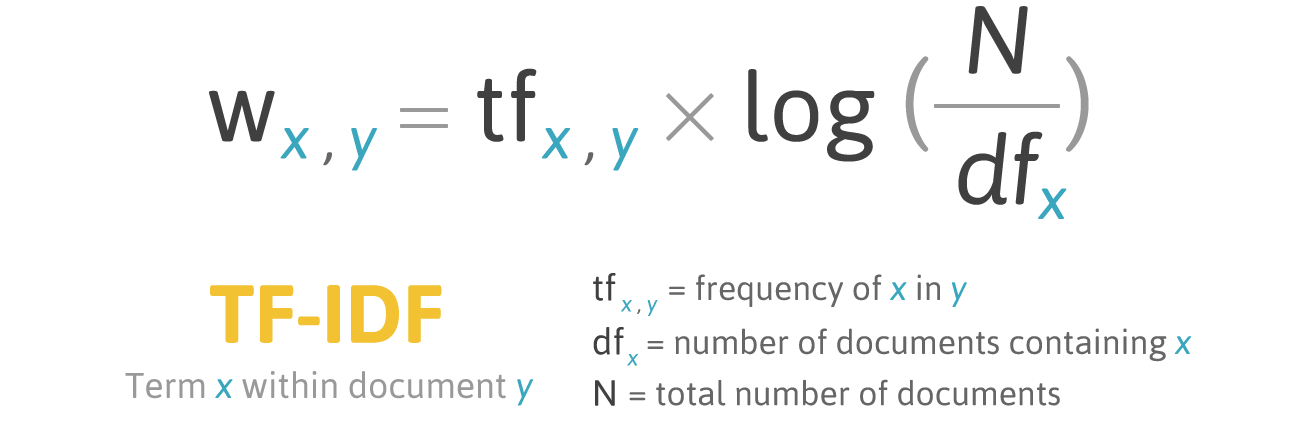


Image from [here](http://filotechnologia.blogspot.com/2014/01/a-simple-java-class-for-tfidf-scoring.html).

In [ ]:
#calc tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
# Fit TF-IDF on train texts
vectorizer = TfidfVectorizer(max_features = 100) # select the top 100 words
vectorizer.fit(train_texts)

# The top 10 words
vectorizer.get_feature_names_out()[:10]

array(['10', 'kz', 'автомобиль', 'алматы', 'ао', 'астана', 'банк',
       'бизнес', 'быть', 'вопрос'], dtype=object)

In [ ]:
# Apply TF-IDF to train and test texts
train_X = vectorizer.transform(train_texts)
test_X  = vectorizer.transform(test_texts)

Once again we transform each text into a word-vector but in this case its components are not integers.

In [ ]:
# Example
train_X.todense()[:2] # show the first 2 rows

matrix([[0.08983244, 0.        , 0.        , 0.        , 0.        ,
         0.08727196, 0.        , 0.10564309, 0.16731611, 0.1763732 ,
         0.        , 0.        , 0.05149755, 0.        , 0.09191034,
         0.        , 0.        , 0.        , 0.        , 0.10282455,
         0.        , 0.20612699, 0.        , 0.09149644, 0.        ,
         0.        , 0.10914692, 0.        , 0.29564301, 0.        ,
         0.        , 0.18245864, 0.3055481 , 0.        , 0.        ,
         0.19749637, 0.        , 0.        , 0.        , 0.        ,
         0.31424824, 0.        , 0.15512866, 0.        , 0.        ,
         0.        , 0.1058993 , 0.16592809, 0.        , 0.16399136,
         0.        , 0.10099457, 0.        , 0.        , 0.        ,
         0.        , 0.09047983, 0.        , 0.08140952, 0.        ,
         0.08000923, 0.        , 0.        , 0.47257151, 0.        ,
         0.1624986 , 0.        , 0.09676606, 0.        , 0.        ,
         0.20198915, 0.08619645, 0

Best parameters:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
Precision:   0.67
Recall:   0.69
F1-measure:   0.67
Accuracy:   0.69
ROC-AUC  =    0.76




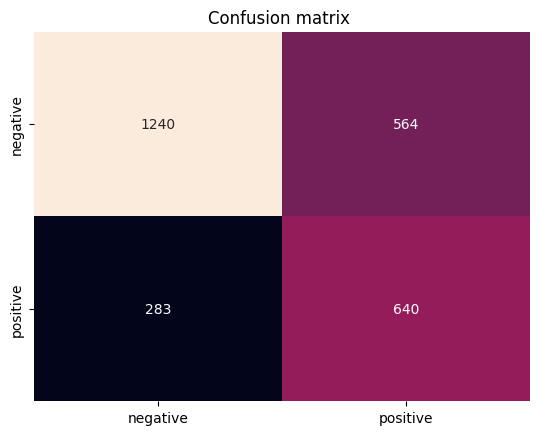

In [ ]:
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight' : ['balanced',None],\
              'penalty':['l1', 'l2', 'elasticnet']}

svr = LogisticRegression(verbose = False)
clf = GridSearchCV(svr, parameters, scoring = 'f1')
clf.fit(train_X, train_y)
pred = clf.predict(test_X)
proba  = clf.predict_proba(test_X)
print('Best parameters: ', clf.best_params_)
show_results(test_y, pred, proba)


F1 has improved, but can we do better?

Number of features:  100
Precision:   0.66
Recall:   0.68
F1-measure:   0.66
Accuracy:   0.68
ROC-AUC  =    0.74




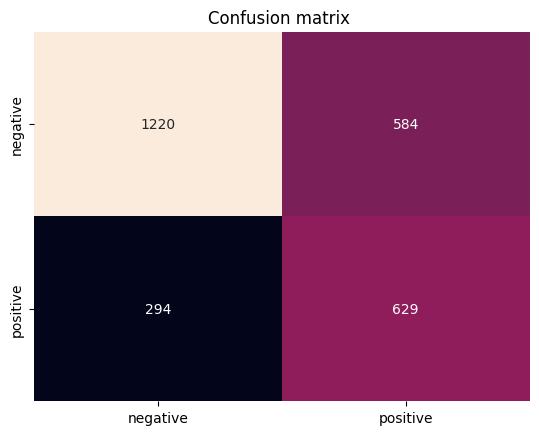









Number of features:  500
Precision:   0.70
Recall:   0.72
F1-measure:   0.70
Accuracy:   0.72
ROC-AUC  =    0.79




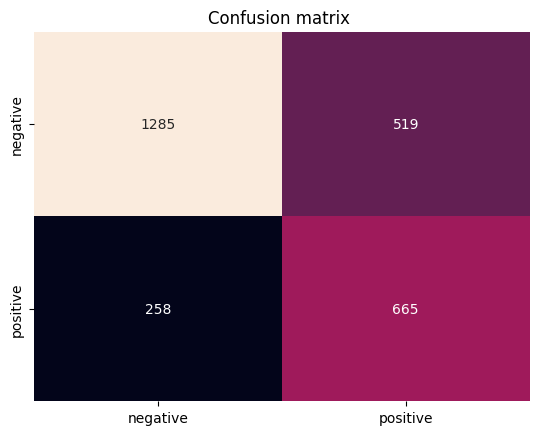









Number of features:  1000
Precision:   0.71
Recall:   0.73
F1-measure:   0.71
Accuracy:   0.72
ROC-AUC  =    0.80




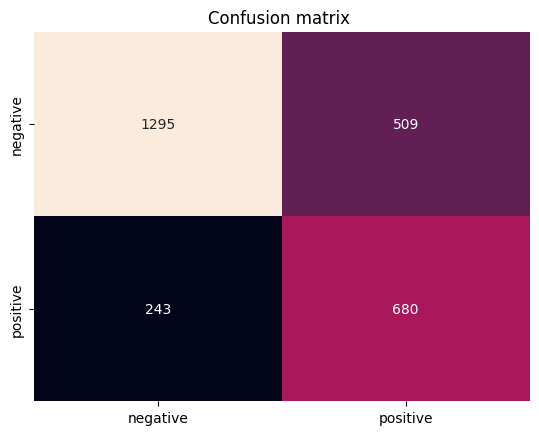









Number of features:  5000
Precision:   0.72
Recall:   0.75
F1-measure:   0.73
Accuracy:   0.74
ROC-AUC  =    0.81




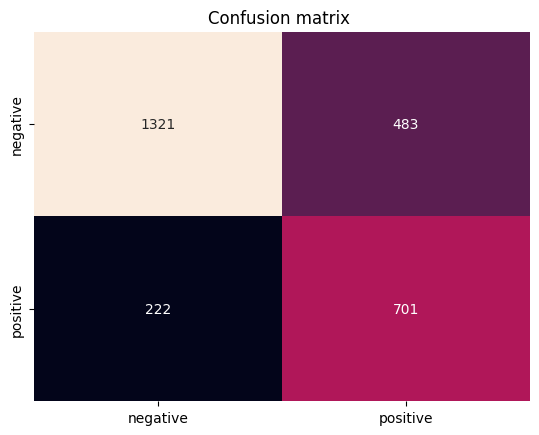









Number of features:  10000
Precision:   0.73
Recall:   0.75
F1-measure:   0.73
Accuracy:   0.75
ROC-AUC  =    0.81




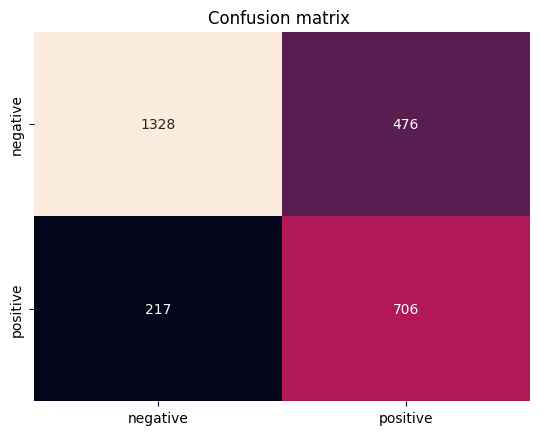









Number of features:  25000
Precision:   0.73
Recall:   0.75
F1-measure:   0.73
Accuracy:   0.75
ROC-AUC  =    0.80




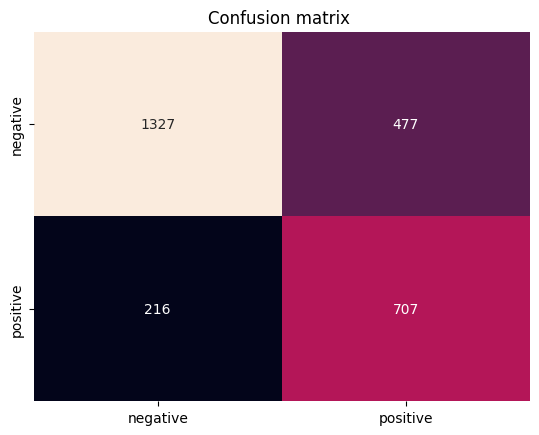









Number of features:  50000
Precision:   0.73
Recall:   0.75
F1-measure:   0.73
Accuracy:   0.74
ROC-AUC  =    0.80




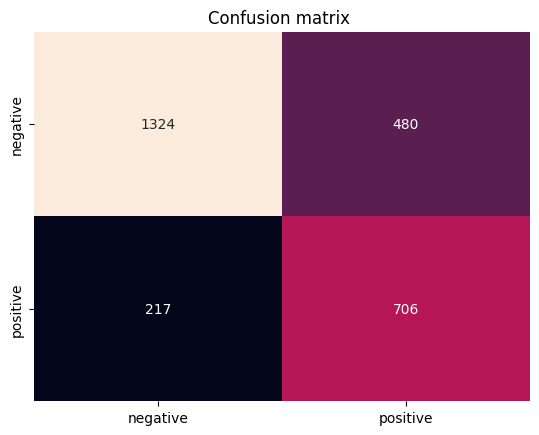









Number of features:  75000
Precision:   0.73
Recall:   0.75
F1-measure:   0.73
Accuracy:   0.74
ROC-AUC  =    0.80




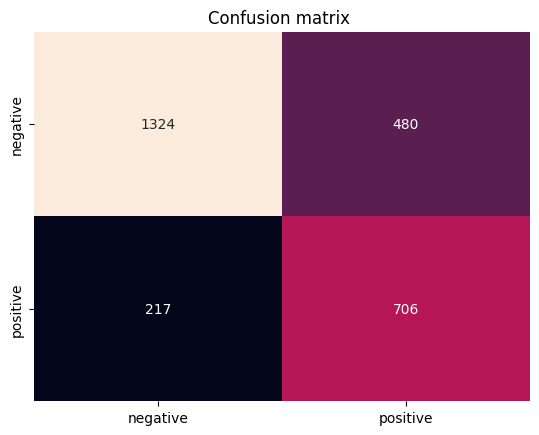









Number of features:  100000
Precision:   0.73
Recall:   0.75
F1-measure:   0.73
Accuracy:   0.74
ROC-AUC  =    0.80




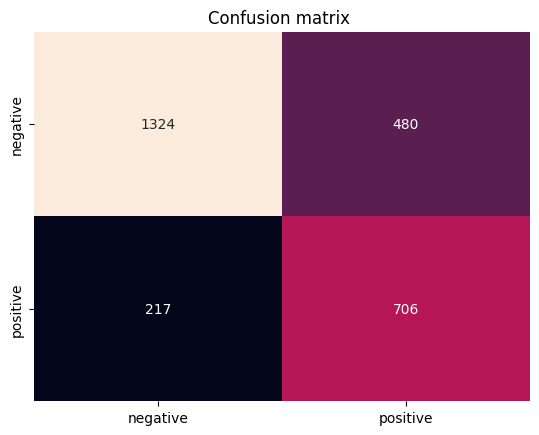

In [ ]:
best_params = {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
f1s = []
word_grid = [100, 500, 1000, 5000, 10000, 25000, 50000, 75000, 100000]
for max_features in word_grid:
    vectorizer = TfidfVectorizer(max_features = max_features)
    vectorizer.fit(train_texts)
    train_X = vectorizer.transform(train_texts)
    test_X  = vectorizer.transform(test_texts)
    clf = LogisticRegression(**best_params)
    clf.fit(train_X, train_y)
    pred = clf.predict(test_X)
    proba  = clf.predict_proba(test_X)
    print('Number of features: ', max_features)
    show_results(test_y, pred, proba)
    print('\n\n\n')
    f1s.append(roc_auc_score(test_y, proba[:,1]))
    print('\n\n\n')

Text(0.5, 1.0, 'F1 result')

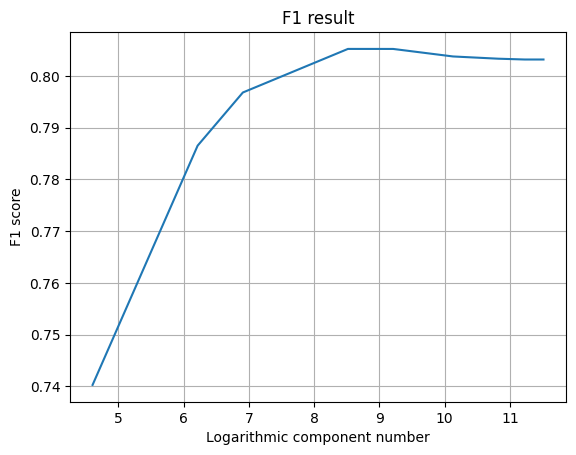

In [ ]:
plt.plot([np.log(x) for x in word_grid], f1s)
plt.grid()
plt.xlabel('Logarithmic component number')
plt.ylabel('F1 score')


plt.title('F1 result')

Once again, we obtain best result for 10000 components.

**Task** Iterate over component number, for each perform GridSearch and find the best configuration.

Number of features:  100
Precision:   0.67
Recall:   0.69
F1-measure:   0.67
Accuracy:   0.69
ROC-AUC  =    0.76




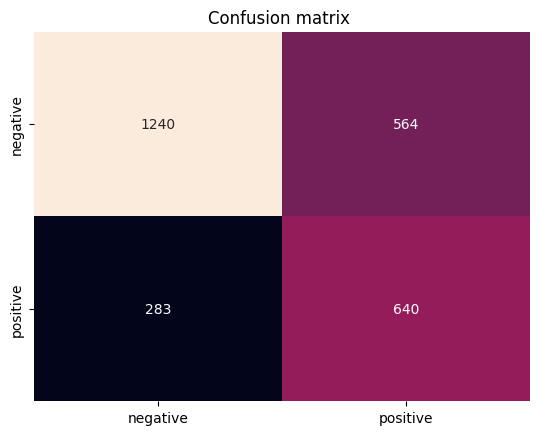





Number of features:  1000
Precision:   0.74
Recall:   0.77
F1-measure:   0.75
Accuracy:   0.77
ROC-AUC  =    0.84




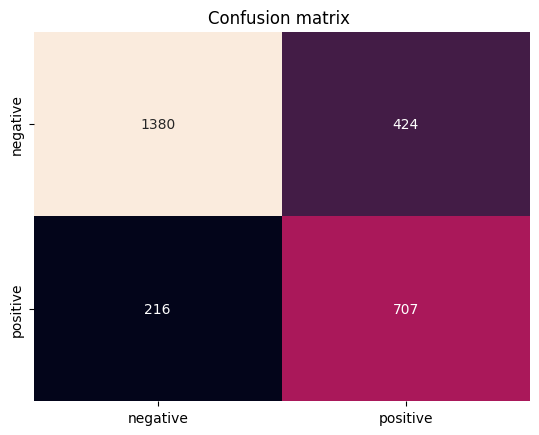





Number of features:  10000
Precision:   0.78
Recall:   0.80
F1-measure:   0.78
Accuracy:   0.80
ROC-AUC  =    0.87




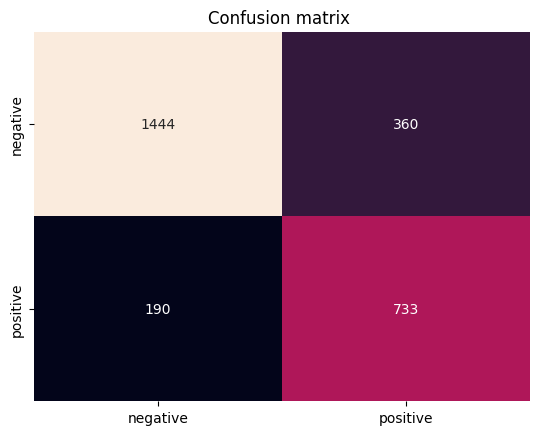





Number of features:  30000
Precision:   0.78
Recall:   0.80
F1-measure:   0.78
Accuracy:   0.80
ROC-AUC  =    0.87




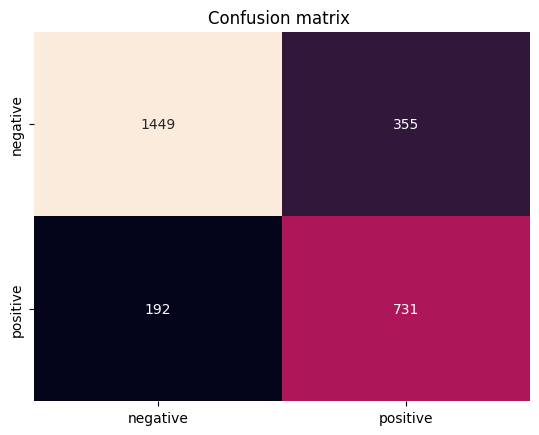

Text(0.5, 1.0, 'F1 result')

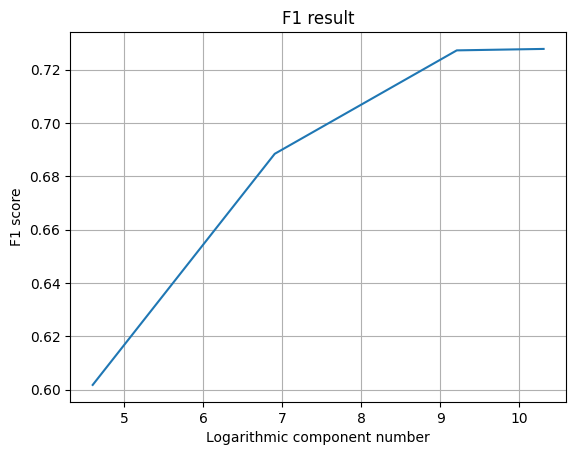

In [ ]:
## YOUR CODE HERE
word_grid = [100, 1000, 10000, 30000]
f1s = []
for max_features in word_grid:
    vectorizer = TfidfVectorizer(max_features = max_features)
    vectorizer.fit(train_texts)
    train_X = vectorizer.transform(train_texts)
    test_X  = vectorizer.transform(test_texts)
    parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'class_weight' : ['balanced',None],\
              'penalty':['l1', 'l2', 'elasticnet']}

    svr = LogisticRegression(verbose = False)
    gscv = GridSearchCV(svr, parameters, scoring = 'f1')
    gscv.fit(train_X, train_y)
    clf = LogisticRegression(**gscv.best_params_)
    clf.fit(train_X, train_y)
    pred = clf.predict(test_X)
    proba  = clf.predict_proba(test_X)
    print('Number of features: ', max_features)
    show_results(test_y, pred, proba)
    print('\n\n\n')
    f1s.append(f1_score(test_y, pred))

plt.plot([np.log(x) for x in word_grid], f1s)
plt.grid()
plt.xlabel('Logarithmic component number')
#plt.xlabels([str(x) for x in word_grid])
plt.ylabel('F1 score')

plt.title('F1 result')

# Support Vector Machine

Let us also try other ML algorithms.

## Theory recap
##Maximal Margin Classifier

In general, if our data can be perfectly separated using a hyperplane, then
there will in fact exist an infinite number of such hyperplanes.

A natural choice is the **maximal margin hyperplane** (also known as the **optimal separating hyperplane**), which is the separating hyperplane that is farthest from the training observations. That is, we can compute the (perpendicular) distance from each training observation to a given separating hyperplane; the smallest such distance is the minimal distance from the observations to the hyperplane, and is known as the **margin**. The maximal margin margin hyperplane is the separating hyperplane for which the margin is largest.

We can then classify a test observation based on which side of the maximal margin hyperplane it lies. This is known as the **maximal margin classifier**.

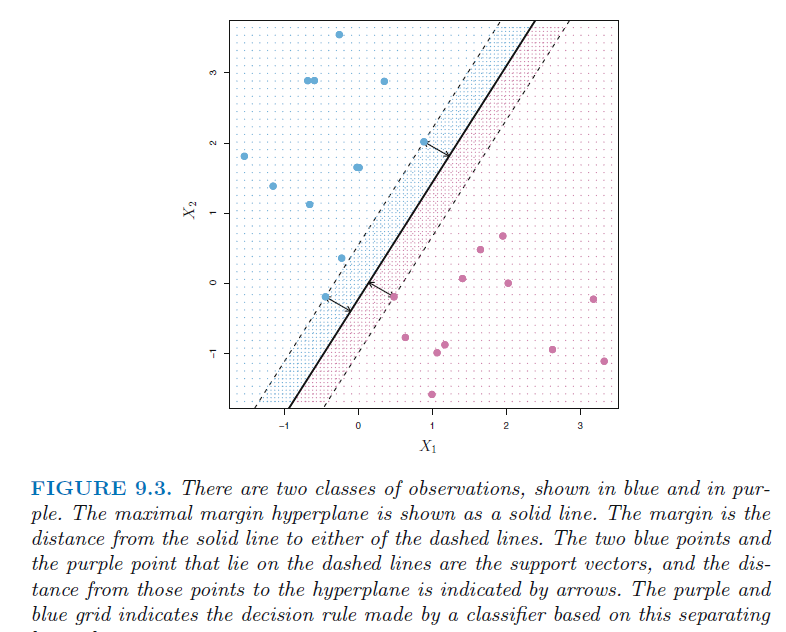

We now consider the task of constructing the maximal margin hyperplane
based on a set of *n* training observations $x_1, .. x_n \in \mathbb{R}^p$ and associated class labels $y_1,.., y_n$,  $y_i = \pm1$. Briefly, the maximal margin hyperplane is the solution to the optimization problem

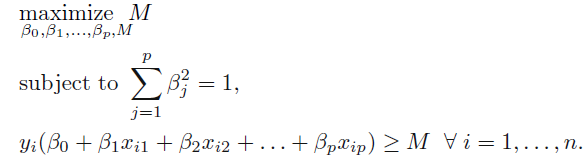

## Soft Margin Classifier



When classes are non-separable, we might be willing to consider a classifier based on a hyperplane that does not perfectly separate the two classes in the interest of:

1) greater robustness to individual observations;

2) better classification of most of the training observations.

That is, it could be worthwhile to misclassify a few training observations
in order to do a better job in classifying the remaining observations.
The **support vector classifier**, sometimes called a **soft margin classifier**  does exactly this. Rather than seeking the largest possible margin so that every observation is not only on the correct side of the hyperplane but also on the correct side of the margin, we instead allow some observations to be on the incorrect side of the margin, or even the incorrect side of the hyperplane. (The margin is soft because it can be violated by some of the training observations.)

The support vector classifier classifies a test observation depending on
which side of a hyperplane it lies. The hyperplane is chosen to correctly separate most of the training observations into the two classes, but may
misclassify a few observations. It is the solution to the optimization problem

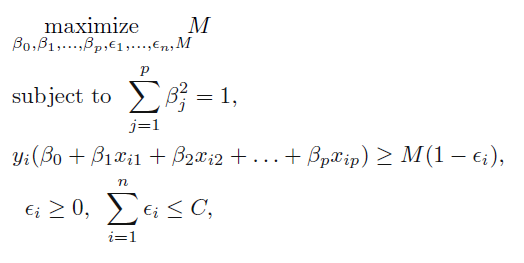

where $C$ is a nonnegative tuning parameter.

$M$ is the width of the margin; we seek to make this quantity as large as possible.

$\epsilon_1,..., \epsilon_n$ are **slack variables** that allow individual observations to be on the wrong side of the margin or the hyperplane.

## Support Vector Machines

The support vector classifier is a natural approach for classification in the
two-class setting, if the boundary between the two classes is linear. However,
in practice we are sometimes faced with non-linear class boundaries. In the case of the support vector classifier, we could address the problem
of possibly non-linear boundaries between classes in a similar way, by
enlarging the feature space using quadratic, cubic, and even higher-order
polynomial functions of the predictors.

This leads us to the following optimization problem:

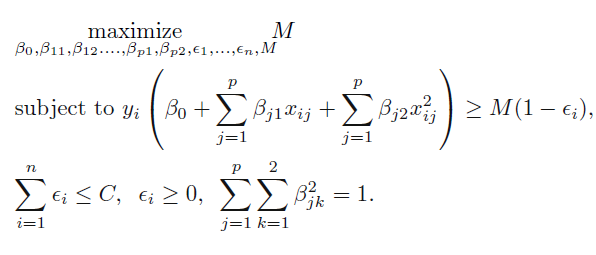

Why does this lead to a non-linear decision boundary? In the enlarged
feature space, the decision boundary is in fact linear.
But in the original feature space, the decision boundary is of the form
$q(x) = 0$, where q is a quadratic polynomial, and its solutions are generally
non-linear.


The **support vector machine (SVM)** is an extension of the support vector
classifier that results from enlarging the feature space in a specific way,
using kernels.

The main idea is that we may want to enlarge our feature space in order to accommodate a non-linear boundary between the classes. The
kernel approach that we describe here is simply an efficient computational
approach for enacting this idea.

However, it turns
out that the solution to the support vector classifier problem
involves only the inner products of the observations (as opposed to the
observations themselves).

**Note** we limit training parameter  `max_iter` to speed up training. Unfortunately, it could affect the result. Thus, you may experiment with training this model without max_iter limit and examine the difference.



Precision:   0.69
Recall:   0.66
F1-measure:   0.67
Accuracy:   0.72
ROC-AUC  =    0.75




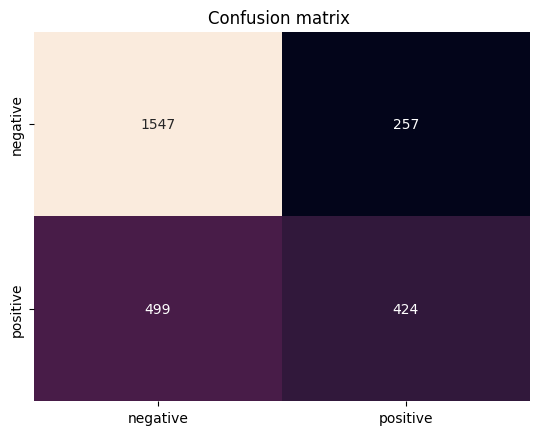

In [ ]:
vectorizer = TfidfVectorizer(max_features = 100)
vectorizer.fit(train_texts)
train_X = vectorizer.transform(train_texts)
test_X  = vectorizer.transform(test_texts)
clf = SVC(verbose = False, probability = True, kernel = 'linear')
clf.fit(train_X, train_y)
pred = clf.predict(test_X)
proba  = clf.predict_proba(test_X)
show_results(test_y, pred, proba)


Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END .............................C=0.001, kernel=linear; total time=  23.9s
[CV] END .............................C=0.001, kernel=linear; total time=  11.6s
[CV] END ................................C=0.001, kernel=rbf; total time=  11.8s
[CV] END ................................C=0.001, kernel=rbf; total time=  12.0s
[CV] END ...............................C=0.001, kernel=poly; total time=  12.3s
[CV] END ...............................C=0.001, kernel=poly; total time=  12.5s
[CV] END ............................C=0.001, kernel=sigmoid; total time=  12.6s
[CV] END ............................C=0.001, kernel=sigmoid; total time=  12.7s
[CV] END ..............................C=0.01, kernel=linear; total time=  12.5s
[CV] END ..............................C=0.01, kernel=linear; total time=  13.3s
[CV] END .................................C=0.01, kernel=rbf; total time=  12.7s
[CV] END .................................C=0.01

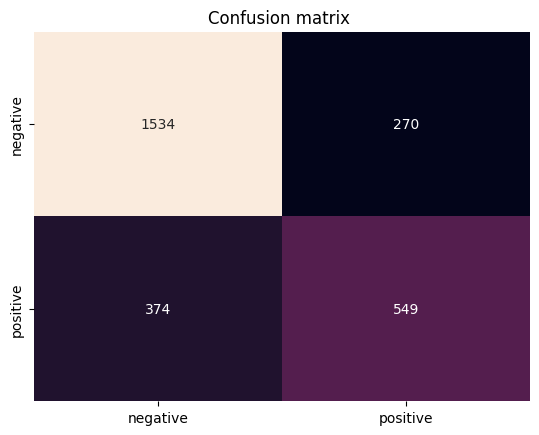

In [ ]:
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[0.001, 0.01, 0.1, 1, 10, 100]}
svr = SVC(probability=True, verbose = False)
clf = GridSearchCV(svr, parameters, scoring = 'f1', verbose=2, cv=2)
clf.fit(train_X, train_y)
print(clf.best_params_)
pred = clf.predict(test_X)
proba  = clf.predict_proba(test_X)
show_results(test_y, pred, proba)

# Multiclass classification - returning to the original problem
**Multiclass or multinomial classification** is the problem of classifying instances into one of three or more classes (classifying instances into one of two classes is called binary classification).

Let's return to the original 3-class classification problem:
`'negative','neutral','positive'`, and the method we studied so far were used for binary classification.

**How can we apply them for multiclass classification?**

There are two main approaches:

1) **one-versus-one** Construct several models, each of which compares a pair of classes. The final classification is performed by assigning the test observation to the class to which it  was most frequently assigned

2) **one-versus-all (or one-versus-rest)** Fit K models, each time comparing one of all the K classes to the remaining K − 1 classes.

In [ ]:
#train test_split
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_y, test_y = train_test_split(texts, y, test_size=0.33, random_state=42, stratify = y)
print(Counter(train_y))

Counter({'neutral': 2703, 'positive': 1872, 'negative': 961})


In [ ]:
vectorizer = TfidfVectorizer(max_features = 100)
vectorizer.fit(train_texts)
train_X = vectorizer.transform(train_texts)
test_X  = vectorizer.transform(test_texts)

In [ ]:
train_y = np.array(train_y)
test_y = np.array(test_y)
train_y_ = np.zeros(train_y.shape)
test_y_ = np.zeros(test_y.shape)

In [ ]:
train_y_[train_y == 'positive'] = 2
test_y_[test_y == 'positive'] = 2
train_y_[train_y == 'neutral'] = 1
test_y_[test_y == 'neutral'] = 1

In [ ]:
parameters = {'estimator__C': [0.001, 0.01, 0.1, 1, 10, 100], \
              'estimator__class_weight' : ['balanced', None], 'estimator__penalty':['l1', 'l2', 'elasticnet']}

my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')

svr = OneVsRestClassifier(LogisticRegression(verbose = False))
clf = GridSearchCV(svr, parameters, scoring=my_scorer)
clf.fit(train_X, train_y_)
predict = clf.predict_proba(test_X)
print('OneVsRest Strategy')
print('Best parameters: ', clf.best_params_)
print("F1 score  = {0:6.2f}".format(clf.score(test_X, test_y_)))

svr = OneVsOneClassifier(LogisticRegression(verbose = False))
clf = GridSearchCV(svr, parameters, scoring=my_scorer)
clf.fit(train_X, train_y_)
predict = clf.predict(test_X)
print('\n\n\nOneVsOne Strategy')
print('Best parameters: ', clf.best_params_)
print("F1 score  = {0:6.2f}".format(clf.score(test_X, test_y_)))

OneVsRest Strategy
Best parameters:  {'estimator__C': 100, 'estimator__class_weight': None, 'estimator__penalty': 'l2'}
F1 score  =   0.59



OneVsOne Strategy
Best parameters:  {'estimator__C': 1, 'estimator__class_weight': None, 'estimator__penalty': 'l2'}
F1 score  =   0.59


In [ ]:
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[0.001, 0.01, 0.1, 1, 10, 100],\
              'decision_function_shape' : ['ovo', 'ovr']}
svr = SVC(verbose = False, probability=True)
clf = GridSearchCV(svr, parameters, scoring=my_scorer, cv=2, verbose=2)
clf.fit(train_X, train_y_)
pred = clf.predict_proba(test_X)
print('Best parameters: ', clf.best_params_)
print("F1 score  = {0:6.2f}".format(f1_score(test_y_, np.argmax(pred, axis=1), average='micro')))

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] END C=0.001, decision_function_shape=ovo, kernel=linear; total time=  15.2s
[CV] END C=0.001, decision_function_shape=ovo, kernel=linear; total time=  15.3s
[CV] END ...C=0.001, decision_function_shape=ovo, kernel=rbf; total time=  15.4s
[CV] END ...C=0.001, decision_function_shape=ovo, kernel=rbf; total time=  15.6s
[CV] END ..C=0.001, decision_function_shape=ovo, kernel=poly; total time=  16.6s
[CV] END ..C=0.001, decision_function_shape=ovo, kernel=poly; total time=  16.0s
[CV] END C=0.001, decision_function_shape=ovo, kernel=sigmoid; total time=  16.2s
[CV] END C=0.001, decision_function_shape=ovo, kernel=sigmoid; total time=  16.8s
[CV] END C=0.001, decision_function_shape=ovr, kernel=linear; total time=  15.7s
[CV] END C=0.001, decision_function_shape=ovr, kernel=linear; total time=  15.6s
[CV] END ...C=0.001, decision_function_shape=ovr, kernel=rbf; total time=  16.0s
[CV] END ...C=0.001, decision_function_shape=o